In [1]:
import os, json, gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy.stats import boxcox
from scipy.signal import resample

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error

import lightgbm as lgb
import optuna

In [2]:
datapath = "../data"

train = sio.loadmat(os.path.join(datapath, "train.mat"))
test = sio.loadmat(os.path.join(datapath, "test.mat"))
reference = sio.loadmat(os.path.join(datapath, "reference.mat"))

print(
f"""Keys
train: {train.keys()}
test : {test.keys()}
ref  : {reference.keys()}
"""
)

Keys
train: dict_keys(['__header__', '__version__', '__globals__', '0001', '0002', '0003', '0004'])
test : dict_keys(['__header__', '__version__', '__globals__', '0001', '0002', '0003', '0004'])
ref  : dict_keys(['__header__', '__version__', '__globals__', '0005'])



In [3]:
train["0001"].shape

(1, 1)

In [4]:
feature_name = ['TA R', 'TA L', 'LG R', 'LG L', 'RF R', 'RF L', 'VL R', 'VL L', 'ST R',
                'ST L', 'GMAX R', 'GMAX L', 'EMI R', 'EMI L', 'DEL R', 'DEL L']

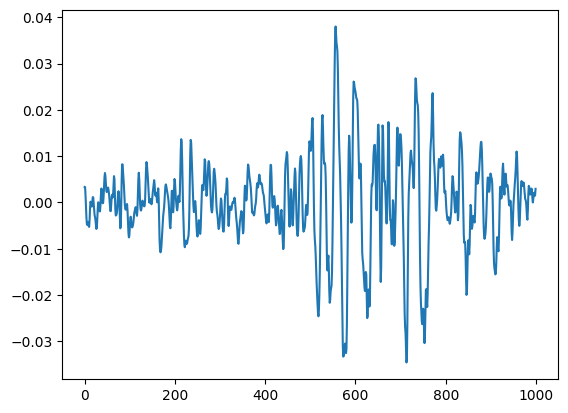

In [5]:
plt.plot(train["0001"][0][0][0][0, 0, :])

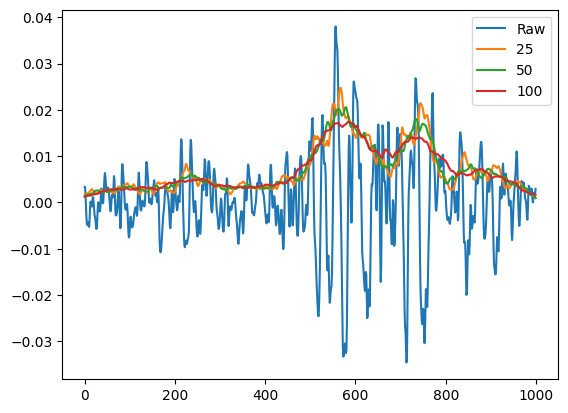

In [6]:
def moveRMS(data, window=25) -> np.ndarray:
    return np.convolve(np.sqrt(data**2), np.ones(window)/window, mode="same")

plt.plot(train["0001"][0][0][0][0, 0, :], label="Raw")
plt.plot(moveRMS(train["0001"][0][0][0][0, 0, :], window=25), label="25")
plt.plot(moveRMS(train["0001"][0][0][0][0, 0, :], window=50), label="50")
plt.plot(moveRMS(train["0001"][0][0][0][0, 0, :], window=100), label="100")
plt.legend()

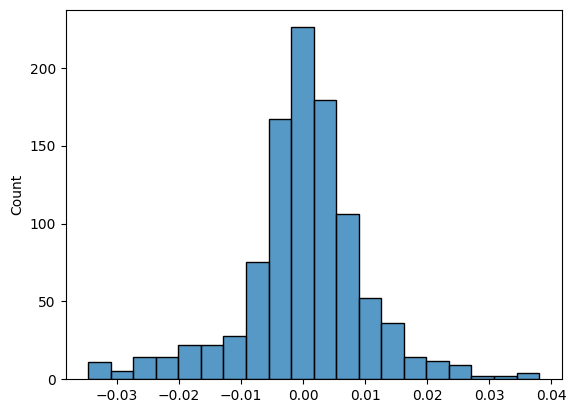

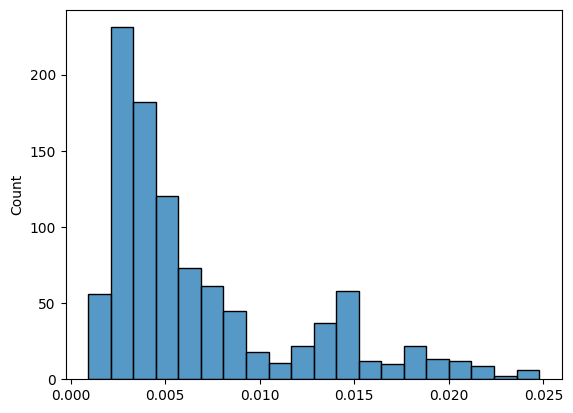

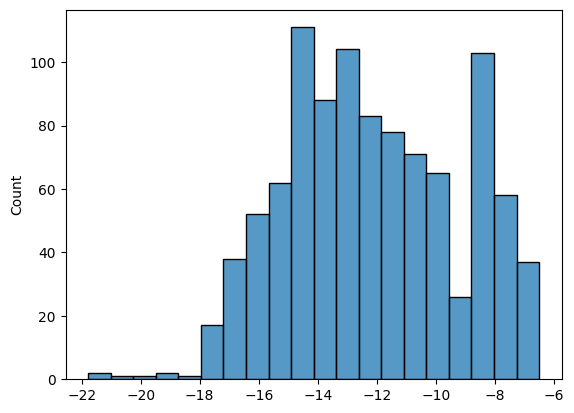

In [7]:
sample_data = train["0001"][0][0][0][0, 0, :]
processed = moveRMS(sample_data)
transformed, *_ = boxcox(processed)

sns.histplot(sample_data, bins=20)
plt.show()
sns.histplot(processed, bins=20)
plt.show()
sns.histplot(transformed, bins=20)
plt.show()

In [8]:
sample_vels = train["0001"][0][0][1]

In [9]:
sample_vels.shape

(319, 3, 30)

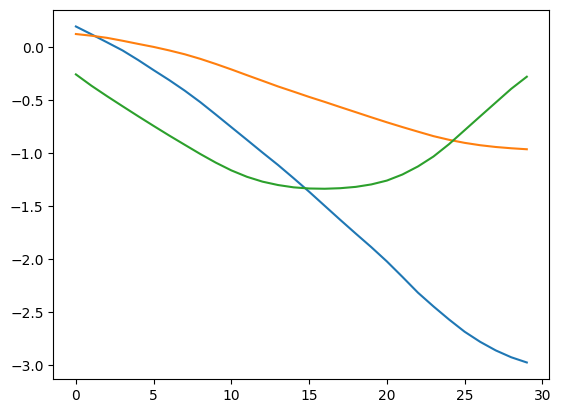

In [10]:
for i in range(3):
    plt.plot(sample_vels[0, i, :])

# データの前処理

In [11]:
train_df = []
for data_key in ["0001", "0002", "0003", "0004"]:
    # x(説明変数のデータフレーム作成)
    x_array = train[data_key][0][0][0]
    y_array = train[data_key][0][0][1]
    
    # (320, 1000, 16) (trial, timepoints, feature) 形式にする
    x_array = x_array.transpose(0, 2, 1)
    y_array = y_array.transpose(0, 2, 1)
    
    print(f"{data_key} length: {y_array.shape[0]*y_array.shape[1]}")
    # 全ユーザーの筋電位データと速度データをデータフレームにする
    user_df = []
    for ind, (x_arr, y_arr) in enumerate(zip(x_array, y_array)):
        feature_df = pd.DataFrame()
        for i, col in enumerate(['TA R', 'TA L', 'LG R', 'LG L', 'RF R', 'RF L', 'VL R', 'VL L', 'ST R',
                                 'ST L', 'GMAX R', 'GMAX L', 'EMI R', 'EMI L', 'DEL R', 'DEL L']):
            # 筋電位データx_arrayの時間をy_arrayの次元数に時間に変更する
            feature_df[f"{col}"] = resample(x_arr[:, i], len(y_arr))
        # 重心速度データ(目的変数)の追加
        for j, col in enumerate(["vel_x", "vel_y", "vel_z"]):
            feature_df[f"{col}"] = y_arr[:, j]
        # 後処理のためにtrialsも情報として追加します
        feature_df["trials"] = ind+1
        user_df.append(feature_df)
    
    user_df = pd.concat(user_df).reset_index(drop=True)
    # 後処理のためにuser_idも情報として追加します
    user_df["user_id"] = data_key
    
    # append
    train_df.append(user_df)
    
    print(f"{data_key} Done!")
    del user_df
    gc.collect()

train_df = pd.concat(train_df).reset_index(drop=True)

0001 length: 9570
0001 Done!
0002 length: 9000
0002 Done!
0003 length: 9600
0003 Done!
0004 length: 9600
0004 Done!


In [12]:
train_df

,TA R,TA L,LG R,LG L,RF R,RF L,VL R,VL L,ST R,ST L,...,GMAX L,EMI R,EMI L,DEL R,DEL L,vel_x,vel_y,vel_z,trials,user_id
0,0.000130,0.002387,-0.012330,-0.008003,-0.005553,0.000014,0.006709,-0.002478,-0.013195,-0.010734,...,-0.005881,-0.001433,0.022564,0.001525,-0.002975,0.193272,0.122026,-0.258740,1,0001
1,-0.001262,-0.000232,0.006781,0.009307,0.004264,0.000898,0.005001,0.002215,-0.011705,0.002972,...,0.005544,-0.022724,-0.012660,-0.000554,-0.008026,0.119459,0.106136,-0.365619,1,0001
2,0.002850,0.000629,-0.007649,-0.003471,0.001748,-0.002814,0.011500,-0.003096,0.017531,-0.001609,...,-0.003913,0.021942,0.005838,0.000412,0.018025,0.043996,0.086143,-0.463906,1,0001
3,-0.003502,-0.001687,0.004225,0.004211,0.002025,0.002696,-0.008585,0.006682,-0.019906,0.001197,...,0.001232,-0.005794,0.003415,0.001892,-0.014464,-0.032592,0.058638,-0.558836,1,0001
4,0.002912,-0.000380,-0.000204,-0.014531,-0.001797,0.000252,0.007000,-0.009013,0.005521,-0.002808,...,-0.000036,0.004984,-0.006266,-0.001587,0.004705,-0.122659,0.029072,-0.652777,1,0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37765,-0.009090,-0.006543,-0.010732,0.009847,0.015848,0.008814,0.006994,0.052570,0.007978,-0.028412,...,-0.016266,0.019399,0.001142,-0.017756,-0.020885,-3.091058,-0.115931,-0.511953,320,0004
37766,0.007748,0.008646,0.026294,-0.007338,-0.004293,-0.009453,-0.000385,-0.037243,-0.007745,0.032170,...,0.004653,-0.030310,0.000443,0.001396,0.008500,-3.131792,-0.152035,-0.455613,320,0004
37767,-0.010767,-0.003604,-0.016503,-0.001864,-0.011771,0.006307,-0.006071,0.007382,0.005299,-0.035973,...,0.010262,0.024939,-0.001622,0.013626,0.009495,-3.154251,-0.186714,-0.381268,320,0004
37768,0.007969,-0.002791,0.004731,0.003029,0.014414,-0.000668,0.003193,0.001436,-0.006763,0.035025,...,-0.007837,-0.007210,0.002407,-0.012311,-0.009387,-3.152731,-0.198442,-0.269258,320,0004


In [13]:
test_df = []
for data_key in ["0001", "0002", "0003", "0004"]:    
    # x(説明変数)のデータフレーム作成
    x_array = test[data_key][0][0][0]
    
    # (320, 1000, 16) (trial, time, feature) 形式にする
    x_array = x_array.transpose(0, 2, 1)
    print(f"{data_key} length: {x_array.shape[0]*30}")
    
    user_df = []
    # 全ユーザーの筋電位データと速度データをデータフレームにする
    for ind, x_arr in enumerate(x_array):
        feature_df = pd.DataFrame()
        for i, col in enumerate(['TA R', 'TA L', 'LG R', 'LG L', 'RF R', 'RF L', 'VL R', 'VL L', 'ST R',
                                 'ST L', 'GMAX R', 'GMAX L', 'EMI R', 'EMI L', 'DEL R', 'DEL L']):
            # trainもtestも重心速度のlengthは30となります
            feature_df[f"{col}"] = resample(x_arr[:, i], 30)
        # trialsも情報として追加します
        feature_df["trials"] = ind+1
        user_df.append(feature_df)
    
    user_df = pd.concat(user_df).reset_index(drop=True)
    # user_idも情報として追加します
    user_df["user_id"] = data_key
    
    # append
    test_df.append(user_df)
    
    print(f"{data_key} Done!")
    del user_df
    gc.collect()

test_df = pd.concat(test_df).reset_index(drop=True)

0001 length: 9570
0001 Done!
0002 length: 9000
0002 Done!
0003 length: 9600
0003 Done!
0004 length: 9600
0004 Done!


In [14]:
test_df

,TA R,TA L,LG R,LG L,RF R,RF L,VL R,VL L,ST R,ST L,GMAX R,GMAX L,EMI R,EMI L,DEL R,DEL L,trials,user_id
0,0.005615,-0.003307,0.011122,-0.033947,-0.044161,-0.029626,0.011900,-0.002778,-0.034056,-0.001060,0.002297,-0.006564,0.019541,0.037699,-0.001090,0.000279,1,0001
1,-0.008634,0.002807,0.002742,-0.105086,0.041544,0.013019,-0.014001,0.011653,0.016137,0.002477,-0.001645,0.003484,-0.036068,-0.005036,-0.001026,-0.001597,1,0001
2,0.008350,-0.001581,-0.000973,0.057026,-0.029650,-0.007606,0.040011,-0.014391,-0.021702,-0.000930,-0.005081,-0.003399,0.017342,-0.002749,0.002031,0.001960,1,0001
3,0.000145,-0.000637,-0.005935,0.035205,0.023630,0.008197,-0.054432,0.007754,0.014599,0.000420,0.003715,0.004299,0.001705,0.003934,-0.004360,-0.000913,1,0001
4,-0.003600,0.000504,0.016128,-0.010149,-0.030805,-0.009307,0.041349,0.005597,-0.001347,-0.001955,0.005075,-0.005724,0.020220,-0.007094,0.007130,-0.000027,1,0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37765,-0.000531,0.003280,0.008821,-0.003922,0.007595,-0.006500,-0.042378,-0.004666,-0.002922,-0.002618,0.015079,-0.003255,0.025629,0.004758,0.000942,0.001486,320,0004
37766,0.003219,-0.001978,0.008133,-0.000937,-0.005371,-0.000625,0.001008,-0.004791,0.005852,0.000808,-0.014639,0.000952,-0.008244,0.006072,-0.000580,0.000741,320,0004
37767,-0.002950,0.000224,-0.011394,0.003457,0.001921,0.004164,0.056768,0.026700,-0.009003,0.000749,0.002948,0.001975,-0.013350,-0.009374,0.002565,-0.001034,320,0004
37768,0.000671,-0.000613,0.000123,-0.002313,-0.005282,-0.000384,-0.055562,-0.038194,0.008160,-0.000796,0.018033,-0.004893,0.019289,0.006134,-0.004126,0.001717,320,0004


# モデルの訓練

In [15]:
# 使用する特徴量を定義します
x_columns = ['TA R', 'TA L', 'LG R', 'LG L', 'RF R', 'RF L', 'VL R', 'VL L', 'ST R',
             'ST L', 'GMAX R', 'GMAX L', 'EMI R', 'EMI L', 'DEL R', 'DEL L']

# 目的変数のカラムを定義します
y_columns = ["vel_x", "vel_y", "vel_z"]

kfold = GroupKFold(n_splits=5)

# lightgbmのハイパーパラメータの設定
params = {
    'objective': 'regression_l2',
    'metric':'rmse',
    'max_depth': -1,
    'learning_rate': 0.01,
    'seed': 777,
    'force_col_wise': True,
    "verbose": -1
}

In [16]:
# 重心加速度x,y,zそれぞれの回帰モデルを作成する
for target in y_columns:
    print(target)
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = x_columns
    
    oof = np.zeros(len(train_df))
    for i, (train_index, valid_index) in enumerate(kfold.split(train_df[x_columns], train_df[target], groups=train_df["trials"])):
        # lightgbmの学習・評価
        lg_train = lgb.Dataset(train_df.loc[train_index, x_columns], label=train_df.loc[train_index, target])
        lg_valid = lgb.Dataset(train_df.loc[valid_index, x_columns], label=train_df.loc[valid_index, target])
        model = lgb.train(params, lg_train, 10000, valid_sets = [lg_train, lg_valid],
                        callbacks=[lgb.early_stopping(stopping_rounds=500, verbose=False), lgb.log_evaluation(1000)])
        
        predict = model.predict(train_df.loc[valid_index, x_columns])
            
        feature_importance[f'importance'] = model.feature_importance()

        print(f"RMSE: {np.sqrt(mean_squared_error(train_df.loc[valid_index, target], predict))}")

        oof[valid_index] = predict
        
        # テストデータでの予測
        test_df[f"{target}_predict{i+1}"] = model.predict(test_df[x_columns])
    
    # クロスバリデーション全体で評価した結果の平均をとります
    train_df[f"{target}_oof"] = oof
    y_true, y_pred = train_df[target], train_df[f"{target}_oof"]
    
    # ここの評価指標をオリジナルのものに変える?
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    
    # 特徴重要度の可視化(チュートリアルではオフにしております)
    # plt.figure(figsize=(12, 8))
    # sns.barplot(data=feature_importance.sort_values(by='importance', ascending=False), x='importance', y='feature');
    # plt.title('50 TOP feature importance');
    # plt.show()

vel_x
[1000]	training's rmse: 1.82186	valid_1's rmse: 2.04983
RMSE: 2.048544701518289
[1000]	training's rmse: 1.84994	valid_1's rmse: 1.94661
RMSE: 1.9450890164443686
[1000]	training's rmse: 1.83953	valid_1's rmse: 1.98482
RMSE: 1.984134284805858
[1000]	training's rmse: 1.82393	valid_1's rmse: 2.0702
[2000]	training's rmse: 1.7049	valid_1's rmse: 2.06891
RMSE: 2.068383758040016
[1000]	training's rmse: 1.84603	valid_1's rmse: 1.9665
[2000]	training's rmse: 1.72871	valid_1's rmse: 1.9624
RMSE: 1.9623766218625116
RMSE: 2.0023215207839935
vel_y
[1000]	training's rmse: 0.817174	valid_1's rmse: 0.909029
RMSE: 0.9088519168852468
[1000]	training's rmse: 0.821782	valid_1's rmse: 0.885121
RMSE: 0.8849324984155686
[1000]	training's rmse: 0.820486	valid_1's rmse: 0.896256
RMSE: 0.8960049647724432
[1000]	training's rmse: 0.8179	valid_1's rmse: 0.903532
RMSE: 0.9032832689037962
[1000]	training's rmse: 0.824213	valid_1's rmse: 0.869497
RMSE: 0.8694310961843594
RMSE: 0.8926293222161101
vel_z
[1000]	tr

In [17]:
train_df

,TA R,TA L,LG R,LG L,RF R,RF L,VL R,VL L,ST R,ST L,...,DEL R,DEL L,vel_x,vel_y,vel_z,trials,user_id,vel_x_oof,vel_y_oof,vel_z_oof
0,0.000130,0.002387,-0.012330,-0.008003,-0.005553,0.000014,0.006709,-0.002478,-0.013195,-0.010734,...,0.001525,-0.002975,0.193272,0.122026,-0.258740,1,0001,-0.336568,-0.225486,-0.387164
1,-0.001262,-0.000232,0.006781,0.009307,0.004264,0.000898,0.005001,0.002215,-0.011705,0.002972,...,-0.000554,-0.008026,0.119459,0.106136,-0.365619,1,0001,-0.335126,-0.123117,-0.130988
2,0.002850,0.000629,-0.007649,-0.003471,0.001748,-0.002814,0.011500,-0.003096,0.017531,-0.001609,...,0.000412,0.018025,0.043996,0.086143,-0.463906,1,0001,0.169953,-0.084965,-0.128138
3,-0.003502,-0.001687,0.004225,0.004211,0.002025,0.002696,-0.008585,0.006682,-0.019906,0.001197,...,0.001892,-0.014464,-0.032592,0.058638,-0.558836,1,0001,1.304350,0.201525,0.175254
4,0.002912,-0.000380,-0.000204,-0.014531,-0.001797,0.000252,0.007000,-0.009013,0.005521,-0.002808,...,-0.001587,0.004705,-0.122659,0.029072,-0.652777,1,0001,1.407148,0.529738,0.446633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37765,-0.009090,-0.006543,-0.010732,0.009847,0.015848,0.008814,0.006994,0.052570,0.007978,-0.028412,...,-0.017756,-0.020885,-3.091058,-0.115931,-0.511953,320,0004,0.435657,0.080321,-0.594736
37766,0.007748,0.008646,0.026294,-0.007338,-0.004293,-0.009453,-0.000385,-0.037243,-0.007745,0.032170,...,0.001396,0.008500,-3.131792,-0.152035,-0.455613,320,0004,0.379985,0.108099,-0.199527
37767,-0.010767,-0.003604,-0.016503,-0.001864,-0.011771,0.006307,-0.006071,0.007382,0.005299,-0.035973,...,0.013626,0.009495,-3.154251,-0.186714,-0.381268,320,0004,-0.083908,0.125816,-0.087917
37768,0.007969,-0.002791,0.004731,0.003029,0.014414,-0.000668,0.003193,0.001436,-0.006763,0.035025,...,-0.012311,-0.009387,-3.152731,-0.198442,-0.269258,320,0004,0.825852,0.357384,0.057430


In [18]:
test_df

,TA R,TA L,LG R,LG L,RF R,RF L,VL R,VL L,ST R,ST L,...,vel_y_predict1,vel_y_predict2,vel_y_predict3,vel_y_predict4,vel_y_predict5,vel_z_predict1,vel_z_predict2,vel_z_predict3,vel_z_predict4,vel_z_predict5
0,0.005615,-0.003307,0.011122,-0.033947,-0.044161,-0.029626,0.011900,-0.002778,-0.034056,-0.001060,...,-0.113982,-0.356632,-0.172211,-0.235171,-0.302638,-1.050478,-1.279865,-1.333009,-0.688507,-1.314456
1,-0.008634,0.002807,0.002742,-0.105086,0.041544,0.013019,-0.014001,0.011653,0.016137,0.002477,...,-0.256603,-0.129280,-0.220347,0.098212,-0.162494,-0.795116,-0.455226,-0.886364,-0.806922,-0.819857
2,0.008350,-0.001581,-0.000973,0.057026,-0.029650,-0.007606,0.040011,-0.014391,-0.021702,-0.000930,...,-0.284328,-0.251806,-0.035599,-0.005271,-0.201280,-0.859128,-0.746207,-0.844231,-0.683269,-1.003031
3,0.000145,-0.000637,-0.005935,0.035205,0.023630,0.008197,-0.054432,0.007754,0.014599,0.000420,...,-0.236191,0.018783,-0.394551,-0.029318,0.007501,-0.877476,-0.894872,-0.944142,-0.966935,-0.850543
4,-0.003600,0.000504,0.016128,-0.010149,-0.030805,-0.009307,0.041349,0.005597,-0.001347,-0.001955,...,0.474640,0.298486,0.454406,0.504107,0.383629,-0.395238,-0.616482,-0.951337,-0.553214,-0.540590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37765,-0.000531,0.003280,0.008821,-0.003922,0.007595,-0.006500,-0.042378,-0.004666,-0.002922,-0.002618,...,0.098190,0.019292,0.065511,0.111210,0.041593,-0.292935,-0.497471,-0.410084,-0.425468,-0.375961
37766,0.003219,-0.001978,0.008133,-0.000937,-0.005371,-0.000625,0.001008,-0.004791,0.005852,0.000808,...,0.169857,0.094403,0.061356,0.083866,0.044778,0.013504,-0.025238,0.021795,0.034165,-0.015741
37767,-0.002950,0.000224,-0.011394,0.003457,0.001921,0.004164,0.056768,0.026700,-0.009003,0.000749,...,-0.035242,0.025179,0.156924,0.098626,0.080330,-0.520722,-0.582347,-0.484316,-0.912453,-0.738847
37768,0.000671,-0.000613,0.000123,-0.002313,-0.005282,-0.000384,-0.055562,-0.038194,0.008160,-0.000796,...,-0.546603,-0.214091,-0.265686,-0.055049,-0.233900,-0.443013,-0.598894,-0.575084,-0.512236,-0.644201


# 評価

In [19]:
scores = []
for user_id, group1 in train_df.groupby("user_id"):
    error_list = []
    for trial, group2 in group1.groupby("trials"):
        # numpyに変換して、transposeで(速度ベクトル, time)に変換すると元データに戻せる
        y_t = group2[["vel_x", "vel_y", "vel_z"]].to_numpy()
        # 予測用
        y_p = group2[["vel_x_oof", "vel_y_oof", "vel_z_oof"]].to_numpy()
        
        trial_rmse = np.sqrt(((y_t-y_p)**2).sum(axis=1).mean())
        
        error_list.append(trial_rmse)
    print(f"{user_id} rmse_3d mean: {np.mean(error_list)}")
    scores.append(np.mean(error_list))
print(f"RMSE_3D Mean: {np.mean(scores)}")


0001 rmse_3d mean: 2.161166964129087
0002 rmse_3d mean: 2.0954753142053306
0003 rmse_3d mean: 2.330997344735296
0004 rmse_3d mean: 2.1301148563808585
RMSE_3D Mean: 2.179438619862643


In [20]:
# 各fold毎の予測結果を平均します
test_df["vel_x_predict"] = test_df[["vel_x_predict1", "vel_x_predict2", "vel_x_predict3", "vel_x_predict4", "vel_x_predict5"]].mean(axis=1)
test_df["vel_y_predict"] = test_df[["vel_y_predict1", "vel_y_predict2", "vel_y_predict3", "vel_y_predict4", "vel_y_predict5"]].mean(axis=1)
test_df["vel_z_predict"] = test_df[["vel_z_predict1", "vel_z_predict2", "vel_z_predict3", "vel_z_predict4", "vel_z_predict5"]].mean(axis=1)

test_df[["vel_x_predict", "vel_y_predict", "vel_z_predict"]].head()

,vel_x_predict,vel_y_predict,vel_z_predict
0,-1.161825,-0.236127,-1.133263
1,0.199504,-0.134102,-0.752697
2,-0.132058,-0.155657,-0.827173
3,-0.417586,-0.126755,-0.906794
4,1.107846,0.423054,-0.611372


# 提出

In [21]:
with open(os.path.join(datapath, "sample_submit.json")) as r:
    sample_submit = json.load(r)

sample_submit.keys()

dict_keys(['sub1', 'sub2', 'sub3', 'sub4'])

In [22]:
for i, (user_id, group1) in enumerate(test_df.groupby("user_id")):
    sub_dict = {}
    for trial, group2 in group1.groupby("trials"):
        # 配列を(30, 3)にします
        y_pred = group2[["vel_x_predict", "vel_y_predict", "vel_z_predict"]].to_numpy()
        # 配列が(30, 3)でなければprintで問題箇所を表示します
        if y_pred.shape != (30,3):
            print(f"Error! trial{trial} shape is not (30, 3), shape: {y_pred.shape}")
        sub_dict[f"trial{trial}"] = y_pred.tolist()
    # 予測に追加(0001はsub1、0002はsub2、0003はsub3、0004はsub4に対応しています)
    sample_submit[f"sub{i+1}"] = sub_dict

with open(os.path.join(datapath, "submission_tutorial.json"), "w") as f:
    json.dump(sample_submit, f)